# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


In [2]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True


In [4]:
torch.cuda.is_available()

True

In [5]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


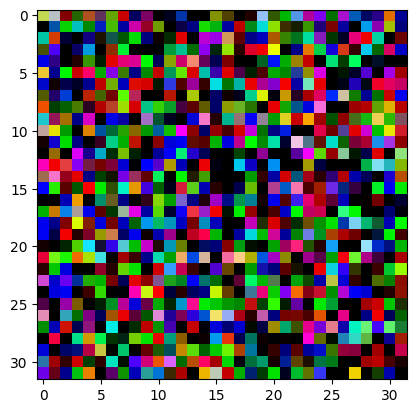

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)}

In [7]:
trainset.classes[y[0]]

'horse'

In [8]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# A more powerful CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample

        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [11]:
device

'cuda'

In [12]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)

            yp = model(x)
            l = loss(yp, y)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(e, running_loss/len(trainloader))
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')

0 1.8083794074290245
1 1.448400798965903
2 1.303016107405543
3 1.1989208743395403
4 1.1216857611675701
5 1.043004903342108
6 0.9653959352037181
7 0.8885079140553389
8 0.8071900694571492
9 0.7247828272602442
10 0.6353444027168976
11 0.5456616224535286
12 0.44849810518724537
13 0.35872920650198026
14 0.26953260707275944
15 0.20386594291919333
16 0.14023425385279728
17 0.10546883818267098
18 0.08623582483900477
19 0.06363472387270855
20 0.05367332629268737
21 0.06530379324846561
22 0.060942379926876795
23 0.04410513740776064
24 0.03342813828512264
25 0.04824386552319197
26 0.031751758608338246
27 0.04549245514771175
28 0.03724758219583641
29 0.02817380001716068
30 0.033770189630677516
31 0.03483571242148061
32 0.03428126657929491
33 0.023597262647298292
34 0.030505096807818658
35 0.03047981288622293
36 0.027080874348504713
37 0.02014210454129931
38 0.030678783360894895
39 0.026497670758665656
40 0.03011905433386183
41 0.01458836007786467
42 0.026185361456776232
43 0.028808688633399956
44 

In [13]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [ ]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()


In [14]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)


Accuracy: 0.608299970626831


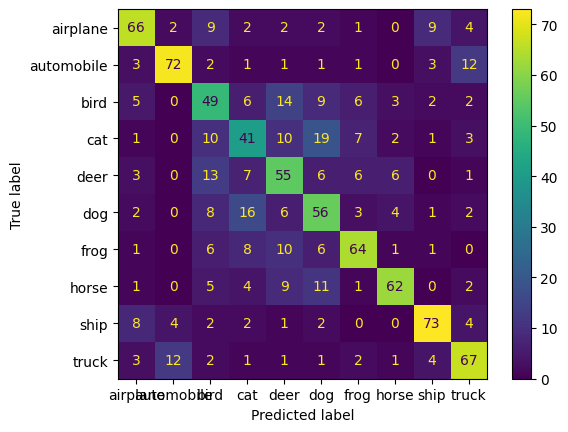

In [15]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()


In [16]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6083


In [17]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break



GT: 9, truck


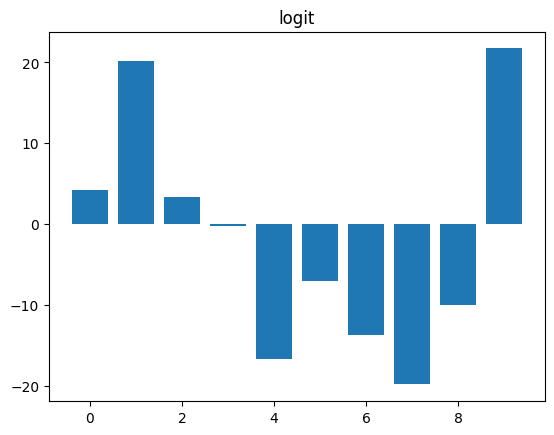

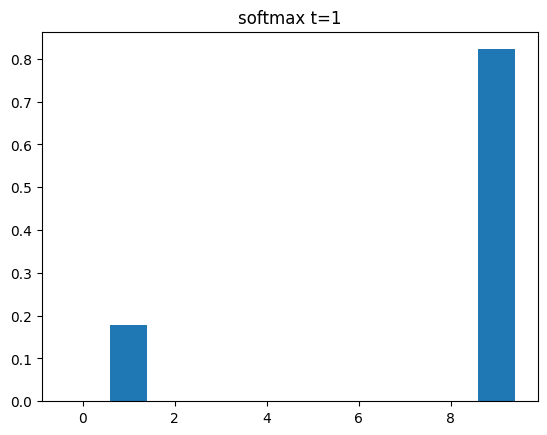

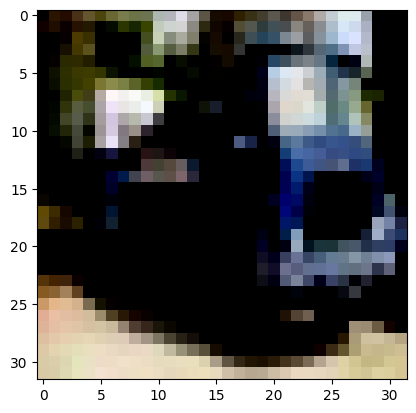

In [18]:
import random
#Example of logit and softmax output
#k=0#the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()




In [19]:
x.shape

torch.Size([128, 3, 32, 32])

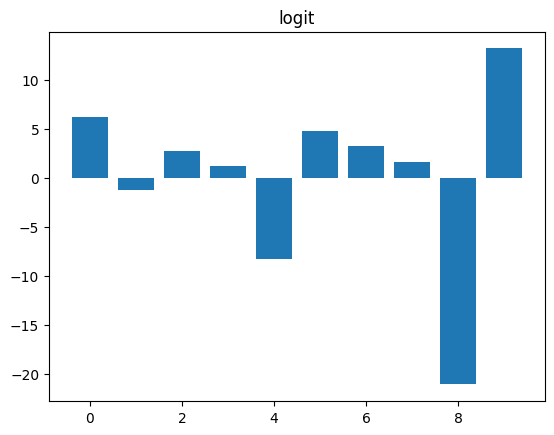

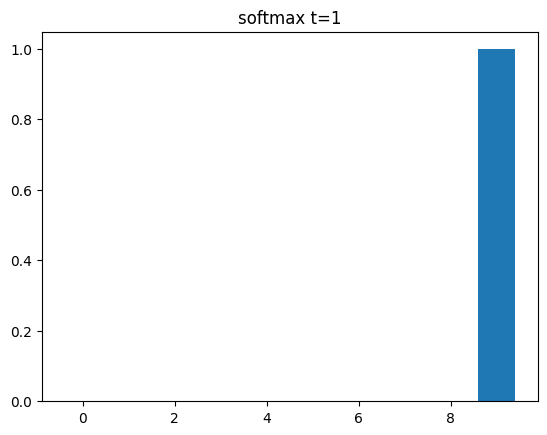

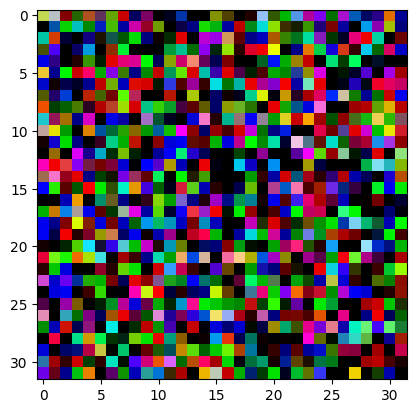

In [20]:
#Example of logit and softmax output
k=0#the kth sample of the batch
output = model(xfake.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0))
plt.show()




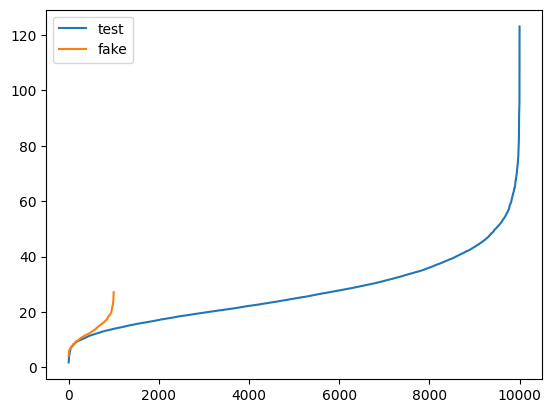

In [21]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)


plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()



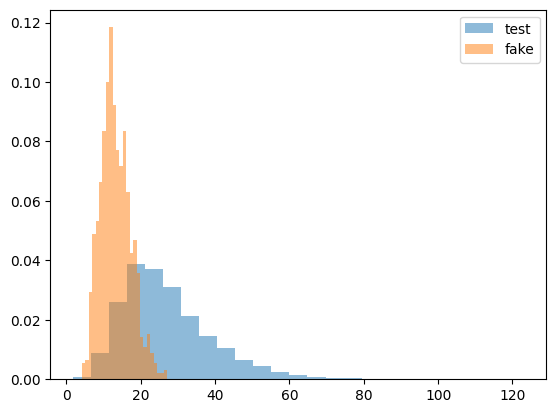

In [22]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


In [23]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [24]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [25]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.3180870867293814
1 0.20283704199601926
2 0.18857395538436178
3 0.1775996520010102
4 0.17147544510376728
5 0.16844397859500193
6 0.16605759025229822
7 0.16278282733981872
8 0.16044974978775015
9 0.15900747378921265
10 0.15791080956873688
11 0.1570085822926153
12 0.15629319717054782
13 0.15570900671165008
14 0.1551577999921101
15 0.15464938098512343
16 0.15405318219109873
17 0.1535354685371794
18 0.15308012376965768
19 0.15263886582058714


In [26]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)

scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)

scores_test_ae = torch.cat(scores_test_ae)



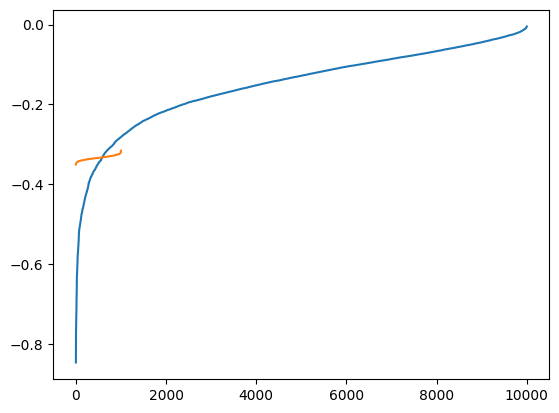

In [27]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


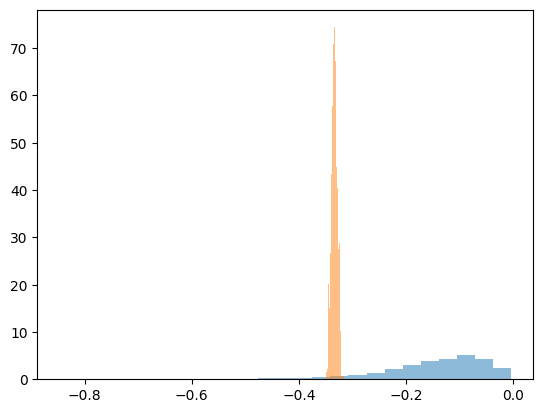

In [28]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



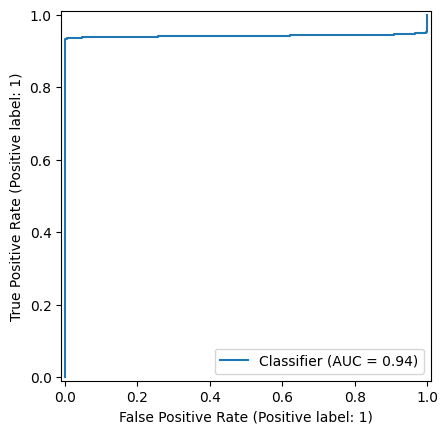

In [32]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

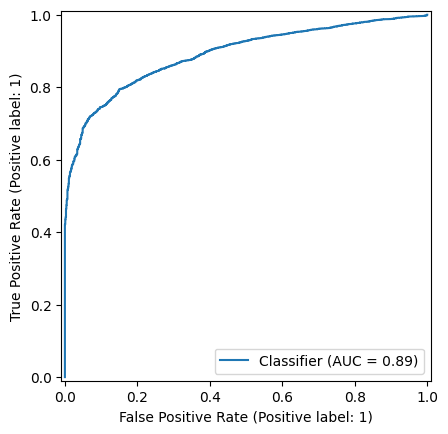

In [33]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

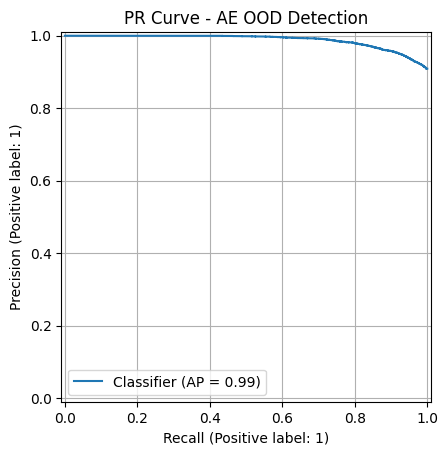

In [34]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y.cpu(), ypred.cpu())
plt.title("PR Curve - AE OOD Detection")
plt.grid(True)
plt.show()


In [35]:
from sklearn.metrics import roc_auc_score, average_precision_score

print(f"AUC-ROC: {roc_auc_score(y.cpu(), ypred.cpu()):.4f}")
print(f"AUC-PR:  {average_precision_score(y.cpu(), ypred.cpu()):.4f}")


AUC-ROC: 0.8911
AUC-PR:  0.9882


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [36]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [37]:
def fgsm_attack(model, images, labels, epsilon, loss_fn):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)

    outputs = model(images)
    loss = loss_fn(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images.detach()


In [38]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [39]:
model.eval()
loss_fn = nn.CrossEntropyLoss()

epsilons = [0, 2/255, 4/255, 8/255, 16/255, 24/255]
accuracies = []

for eps in epsilons:
    correct = 0
    total = 0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        x_adv = fgsm_attack(model, x, y, eps, loss_fn)
        preds = model(x_adv).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"Epsilon: {eps:.3f} - Accuracy: {acc:.4f}")
    accuracies.append(acc)


Epsilon: 0.000 - Accuracy: 0.3034
Epsilon: 0.008 - Accuracy: 0.2747
Epsilon: 0.016 - Accuracy: 0.2484
Epsilon: 0.031 - Accuracy: 0.1994
Epsilon: 0.063 - Accuracy: 0.1390
Epsilon: 0.094 - Accuracy: 0.0975


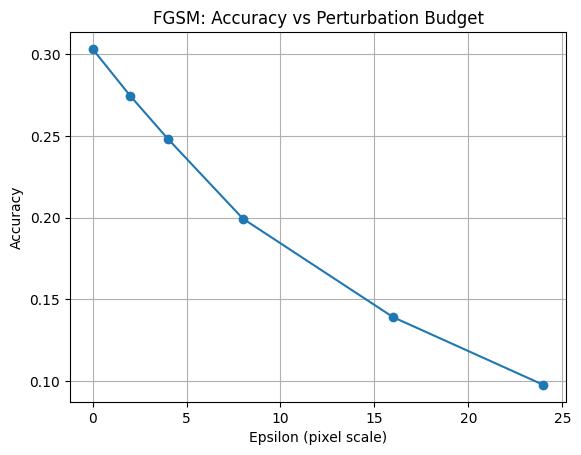

In [40]:
plt.plot([255*e for e in epsilons], accuracies, marker='o')
plt.title("FGSM: Accuracy vs Perturbation Budget")
plt.xlabel("Epsilon (pixel scale)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


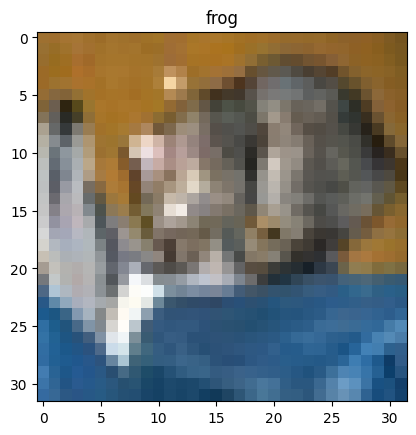

classifier is already wrong or target label same as GT!


In [51]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')

    while not done: #untargeted attack until success!


        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted

        l = loss(output,yt)
        l.backward()


        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted

        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True

        if targeted_attack and output.argmax().item() == target:

            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True


    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())


In [52]:
x.shape

torch.Size([1, 3, 32, 32])

In [53]:
diff = x_adv - x
diff_single = diff[0]  # shape: [3, 32, 32]
diff_img = inv(diff_single.cpu().detach())  # shape [3, 32, 32]


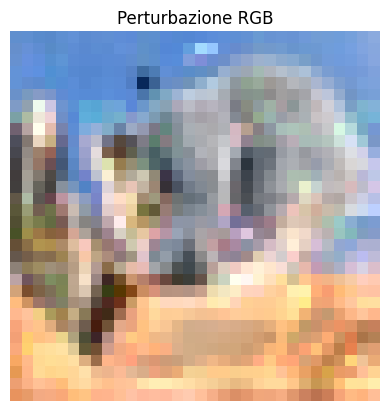

In [54]:
plt.imshow(diff_img.permute(1, 2, 0))  # shape [32, 32, 3]
plt.title("Perturbazione RGB")
plt.axis("off")
plt.show()




### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [55]:
model_adv = CNN().to(device)
optimizer = torch.optim.Adam(model_adv.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
epsilon = 8/255  # tipico valore per FGSM

for epoch in range(epochs):
    model_adv.train()
    running_loss = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)

        # Genera FGSM on-the-fly
        x_adv = fgsm_attack(model_adv, x, y, epsilon, loss_fn)

        # Combina originali e avversari
        x_combined = torch.cat([x, x_adv], dim=0)
        y_combined = torch.cat([y, y], dim=0)

        preds = model_adv(x_combined)
        loss = loss_fn(preds, y_combined)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


Epoch 1, Loss: 1.9321
Epoch 2, Loss: 1.6822
Epoch 3, Loss: 1.5771
Epoch 4, Loss: 1.5068
Epoch 5, Loss: 1.4471
Epoch 6, Loss: 1.3938
Epoch 7, Loss: 1.3340
Epoch 8, Loss: 1.2817
Epoch 9, Loss: 1.2247
Epoch 10, Loss: 1.1695


In [56]:
torch.save(model_adv.state_dict(), "model_adv.pth")


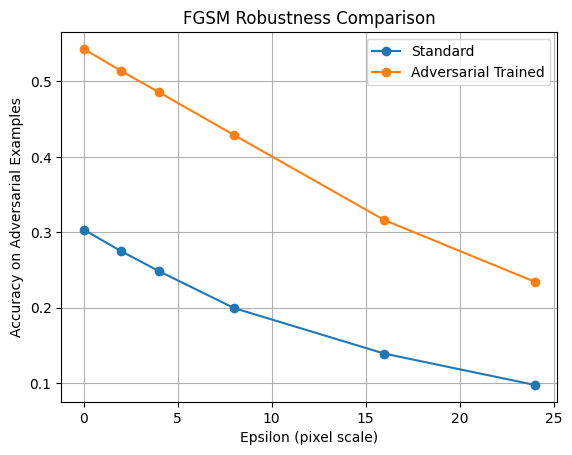

In [57]:
def evaluate_fgsm_accuracy(model, epsilons, dataloader, loss_fn):
    model.eval()
    accs = []
    for eps in epsilons:
        correct, total = 0, 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x_adv = fgsm_attack(model, x, y, eps, loss_fn)
            preds = model(x_adv).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        accs.append(correct / total)
    return accs

epsilons = [0, 2/255, 4/255, 8/255, 16/255, 24/255]
loss_fn = nn.CrossEntropyLoss()

acc_std = evaluate_fgsm_accuracy(model, epsilons, testloader, loss_fn)
acc_adv = evaluate_fgsm_accuracy(model_adv, epsilons, testloader, loss_fn)

# Plot
plt.plot([255*e for e in epsilons], acc_std, label="Standard", marker='o')
plt.plot([255*e for e in epsilons], acc_adv, label="Adversarial Trained", marker='o')
plt.xlabel("Epsilon (pixel scale)")
plt.ylabel("Accuracy on Adversarial Examples")
plt.title("FGSM Robustness Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
def get_ood_scores(model, dataloader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            max_probs = probs.max(dim=1)[0]  # score = max softmax
            scores.extend(max_probs.cpu().numpy())
    return np.array(scores)


In [59]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score

def evaluate_ood_scores(id_scores, ood_scores, label):
    y_true = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
    y_pred = np.concatenate([id_scores, ood_scores])

    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.title(f"ROC Curve - {label}")
    plt.grid(True)
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_pred)
    plt.title(f"PR Curve - {label}")
    plt.grid(True)
    plt.show()

    print(f"{label} - AUC ROC: {roc_auc:.4f}, AUC PR: {pr_auc:.4f}")


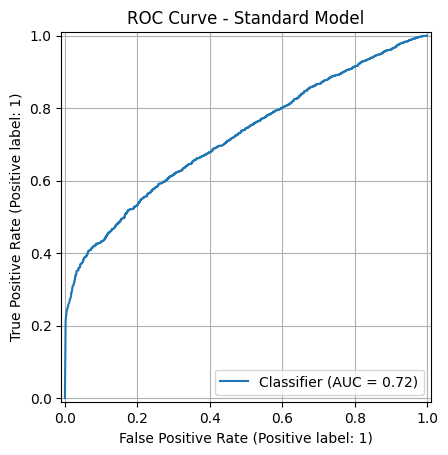

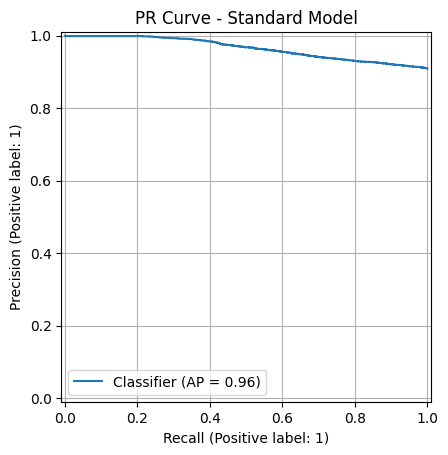

Standard Model - AUC ROC: 0.7210, AUC PR: 0.9650


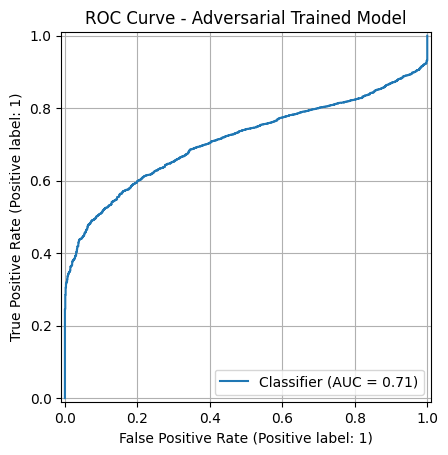

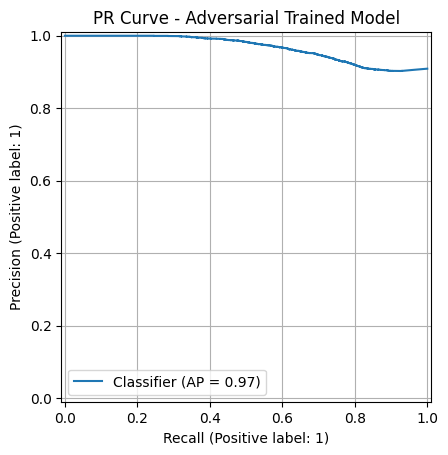

Adversarial Trained Model - AUC ROC: 0.7117, AUC PR: 0.9665


In [60]:
# Score = max softmax
id_scores_std = get_ood_scores(model, testloader, device)
ood_scores_std = get_ood_scores(model, fakeloader, device)

id_scores_adv = get_ood_scores(model_adv, testloader, device)
ood_scores_adv = get_ood_scores(model_adv, fakeloader, device)

evaluate_ood_scores(id_scores_std, ood_scores_std, "Standard Model")
evaluate_ood_scores(id_scores_adv, ood_scores_adv, "Adversarial Trained Model")


---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


Exercise 3.3


In [61]:
def targeted_fgsm(model, image, target_label, epsilon, loss_fn):
    image = image.clone().detach().to(device).requires_grad_(True)
    target = torch.tensor([target_label]).to(device)

    output = model(image)
    loss = loss_fn(output, target)

    model.zero_grad()
    loss.backward()

    # Inverti direzione per minimizzare la loss della classe target
    perturbed_image = image - epsilon * image.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

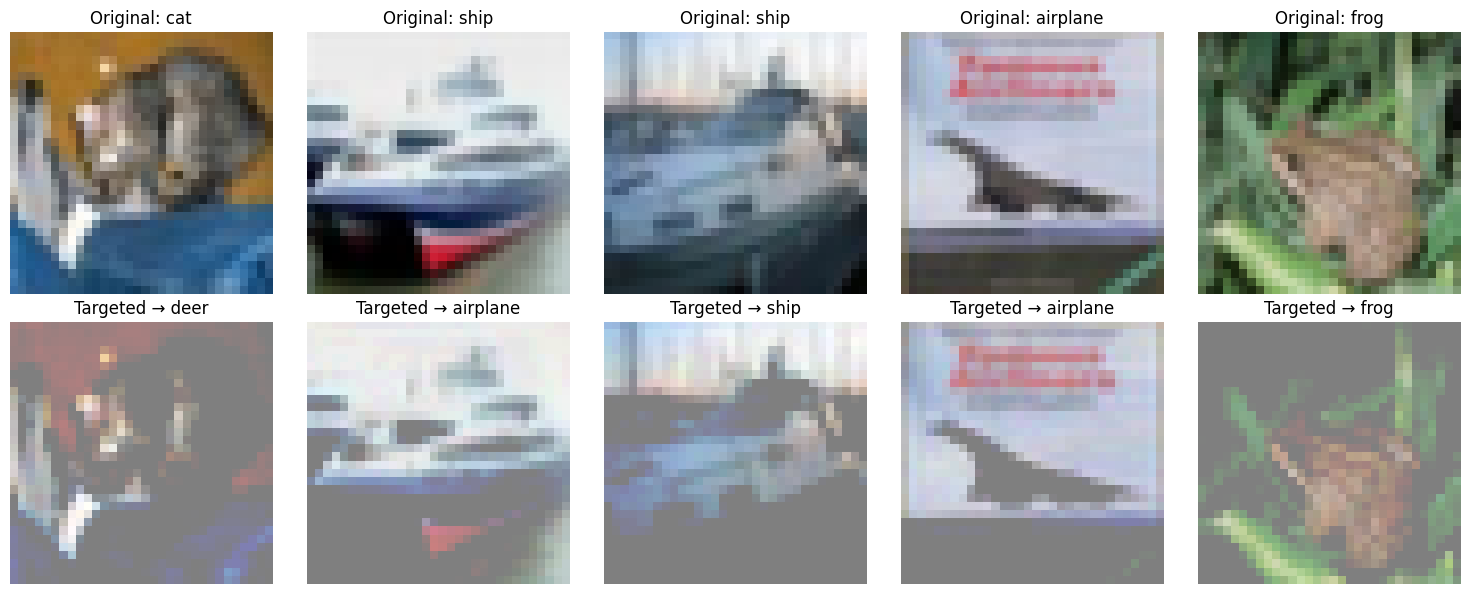

In [62]:
sample_ids = [0, 1, 2, 3, 4]
target_class = class_dict["deer"]  #forza ogni immagine a cercare di essere classificata come "deer"

model.eval()
epsilon = 0.03

fig, axes = plt.subplots(2, len(sample_ids), figsize=(15, 6))

for i, sid in enumerate(sample_ids):
    x, y = testset[sid]
    x = x.unsqueeze(0).to(device)
    y_true = y

    # FGSM targeted attack
    x_adv = targeted_fgsm(model, x, target_class, epsilon, loss_fn)

    # Previsioni
    y_pred = model(x_adv).argmax(dim=1).item()

    # Visualizza originale
    axes[0, i].imshow(inv(x[0]).permute(1, 2, 0).cpu())
    axes[0, i].set_title(f"Original: {testset.classes[y_true]}")
    axes[0, i].axis("off")

    # Visualizza attaccata
    axes[1, i].imshow(inv(x_adv[0]).permute(1, 2, 0).cpu())
    axes[1, i].set_title(f"Targeted → {testset.classes[y_pred]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [63]:
# Conta quanti attacchi hanno ottenuto come output la classe target.
def targeted_success_rate(model, dataloader, target_class, epsilon):
    model.eval()
    success, total = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        mask = y != target_class
        x, y = x[mask], y[mask]
        if len(y) == 0:
            continue
        x.requires_grad = True
        target = torch.full_like(y, target_class)

        output = model(x)
        loss_val = loss_fn(output, target)
        model.zero_grad()
        loss_val.backward()

        x_adv = x - epsilon * x.grad.sign()
        x_adv = torch.clamp(x_adv, 0, 1)

        preds = model(x_adv).argmax(1)
        success += (preds == target).sum().item()
        total += len(y)

    return success / total


target = class_dict["deer"]
rate = targeted_success_rate(model, testloader, target, epsilon=0.03)
print(f"Targeted attack success rate to '{testset.classes[target]}': {rate:.2%}")


Targeted attack success rate to 'deer': 17.81%


In [64]:
#Questo misura quante volte il modello sbaglia la previsione dopo un attacco FGSM non mirato (cioè solo per confondere il modello).
def untargeted_success_rate(model, dataloader, epsilon):
    model.eval()
    success, total = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        x.requires_grad = True

        output = model(x)
        loss_val = loss_fn(output, y)
        model.zero_grad()
        loss_val.backward()

        x_adv = x + epsilon * x.grad.sign()
        x_adv = torch.clamp(x_adv, 0, 1)

        preds = model(x_adv).argmax(1)
        success += (preds != y).sum().item()
        total += len(y)

    return success / total


rate_untargeted = untargeted_success_rate(model, testloader, epsilon=0.03)
print(f"Untargeted attack success rate: {rate_untargeted:.2%}")


Untargeted attack success rate: 79.69%


L’attacco untargeted ha una probabilità molto alta di confondere il modello: più di 8 immagini su 10 vengono classificate in modo errato.

L’attacco targeted, invece, è molto più difficile: deve spingere l’immagine verso una specifica classe, non solo causare errore.

Questo è esattamente ciò che ci si aspetta: targeted FGSM è più sottile, e meno efficace con un solo passo (1-step FGSM).
